In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 550 # time window post-swim
t_sig = 300 # time used for significance test after swim

## Overview of swim data

['03272019', 'Fish2-1', 'Gain Adaptation (before ablation)']


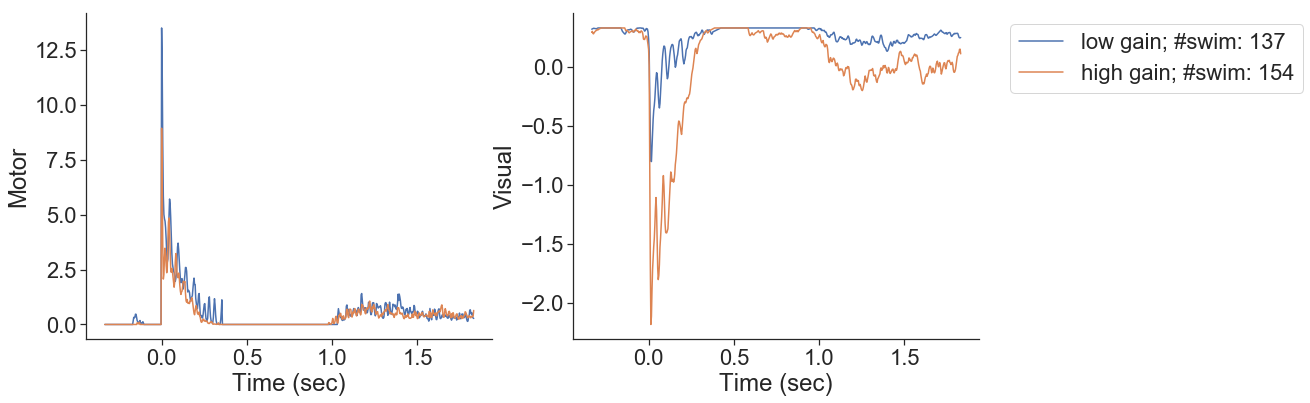

['03272019', 'Fish2-2', 'Delayed feedback (before ablation)']


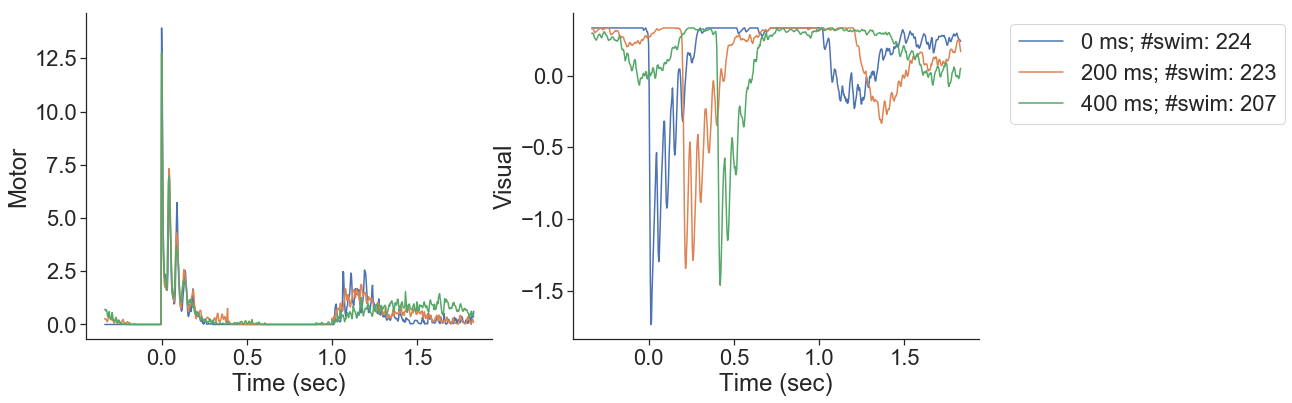

['03272019', 'Fish2-3', 'Gain adaptation (after ablation)']


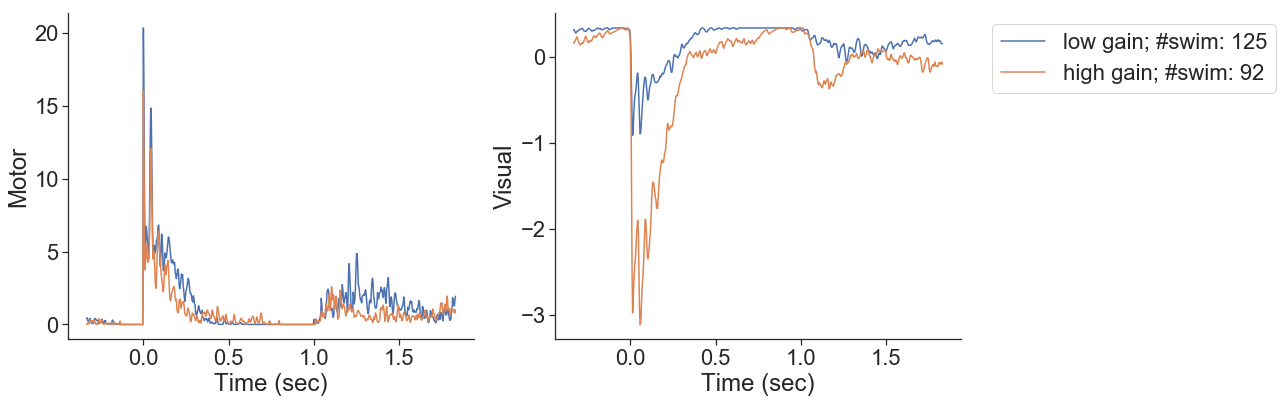

['03282019', 'Fish2-1', 'Delayed feedback (before ablation)']


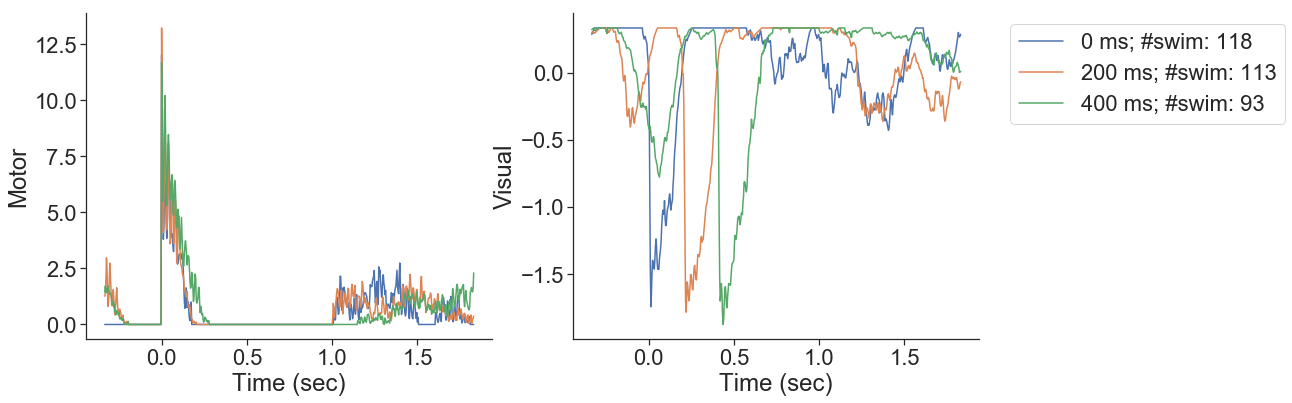

['03282019', 'Fish2-2', 'Gain adaptation (before ablation)']


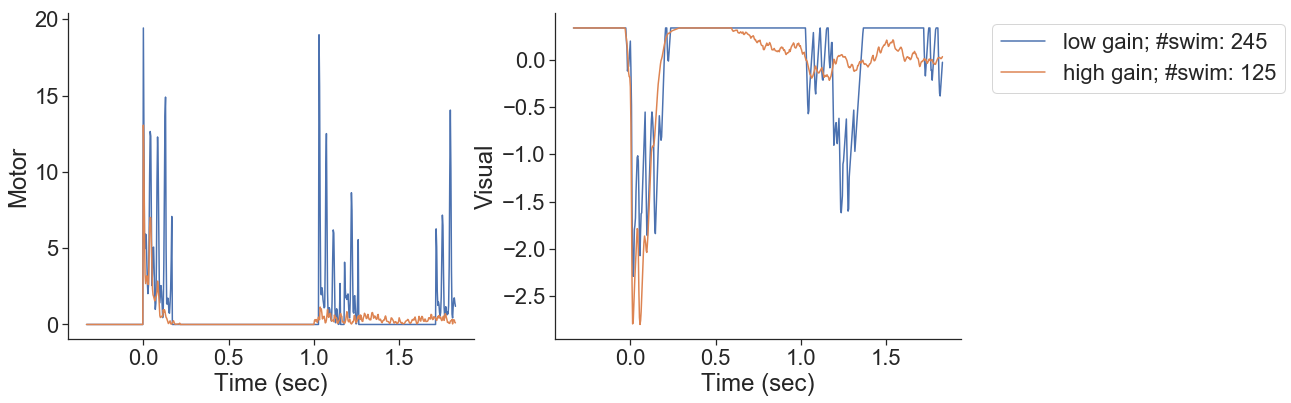

['03282019', 'Fish2-3', 'Gain adaptation (after ablation)']


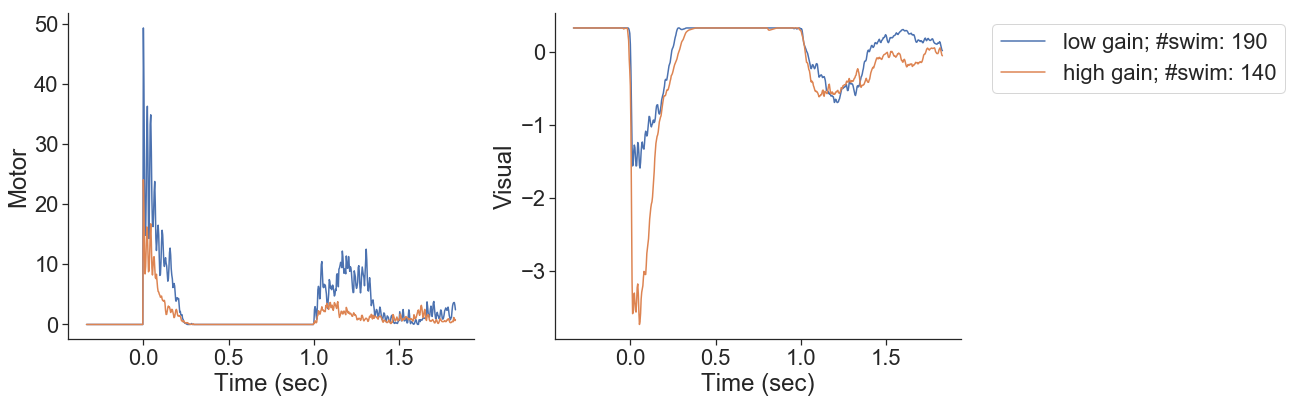

['03282019', 'Fish2-4', 'Delayed feedback (after ablation)']


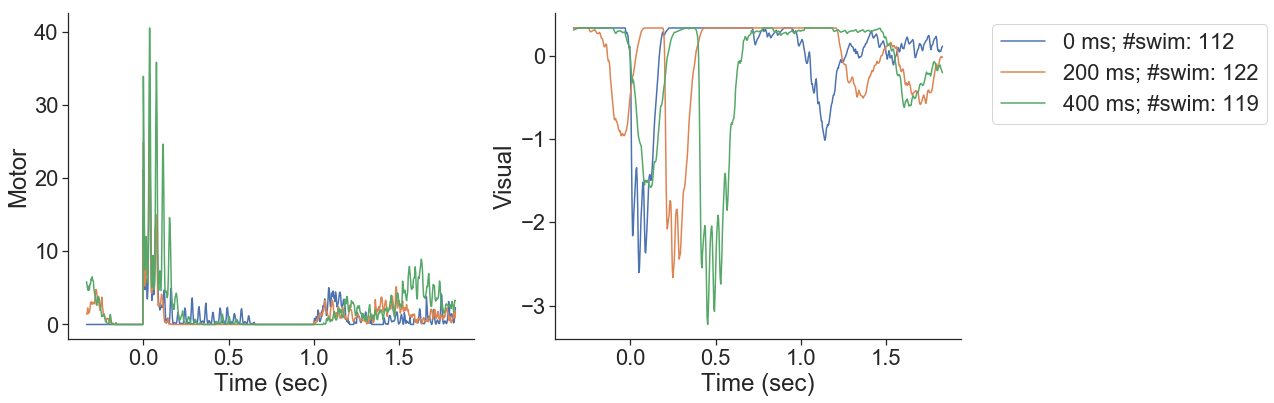

In [38]:
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    task_period = _['task_period'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    
    trial_valid_ = np.ones(len(swim_starts)).astype('bool')
    for n, n_swim in enumerate(swim_starts[:-1]):        
        # examine the swim with short inter-swim-interval
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid_[n] = False
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax = ax.flatten()
    
    print([folder, fish, task_type])
    if 'Gain' in task_type:
        labels = ['low gain', 'high gain']
    if 'Delay' in task_type:
        labels = ['0 ms', '200 ms', '400 ms']
    for n in range(task_period.max()):
        ax[0].plot(np.arange(-t_pre, t_post)/300, p_swim[(task_period==n+1) & trial_valid_].mean(axis=0))
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('Motor')
    sns.despine()
    
    for n in range(task_period.max()):
        ax[1].plot(np.arange(-t_pre, t_post)/300, visu[(task_period==n+1) & trial_valid_].mean(axis=0), label=labels[n]+f'; #swim: {(task_period==n+1).sum()}')
    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Visual')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2)
    
    plt.show()

## Comparing swim data before and after ablation

* Number of swim
* Swim length
* Swim power

In [25]:
swim_len_list = []
swim_type_list = []
swim_power_list = []
fish_id = []

for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    if 'Delay' in task_type:
        continue
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['task_period'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    swim_len = swim_ends - swim_starts
    swim_type_list.extend(task_period)
    fish_id.extend([folder+'_'+fish+'_'+task_type]*len(swim_len))
    # fish_id.extend([folder+'_'+fish]*len(swim_len))
    swim_len_list.extend(swim_len)
    swim_power = np.zeros(len(swim_len))
    for n_swim in range(len(swim_len)):
        swim_power[n_swim] = p_swim[n_swim, t_pre:(t_pre+swim_len[n_swim])].mean()
        if np.isnan(swim_power[n_swim]):
            print(swim_len[n_swim])
    swim_power_list.extend(swim_power)

fish_behavior = [('fish_id', fish_id), ('task_type', swim_type_list), ('swim_length', swim_len_list), ('swim_power', swim_power_list)]
fish_behavior = pd.DataFrame.from_items(fish_behavior)

/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


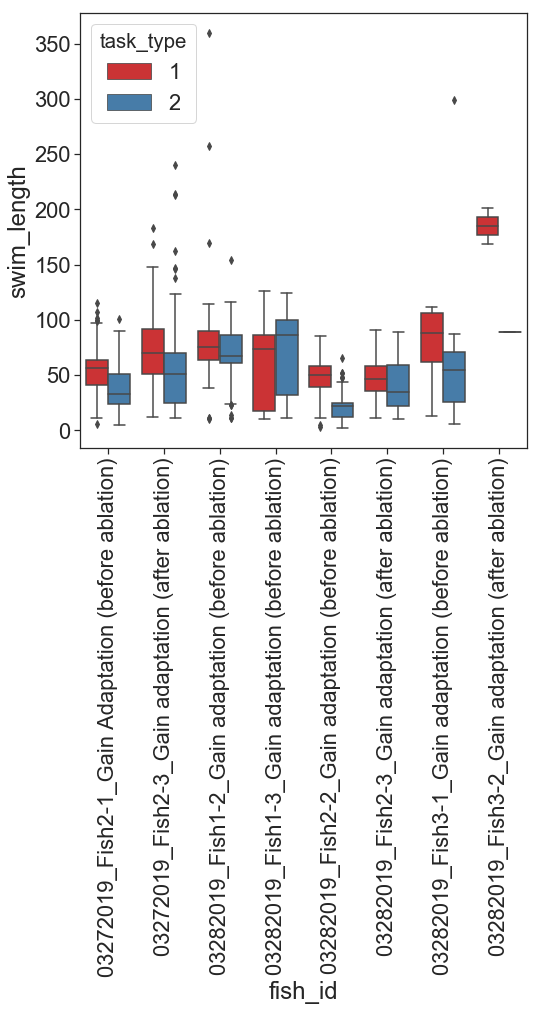

In [32]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="fish_id", y="swim_length", hue="task_type", data=fish_behavior, palette="Set1")
plt.xticks(rotation=90)
plt.show()

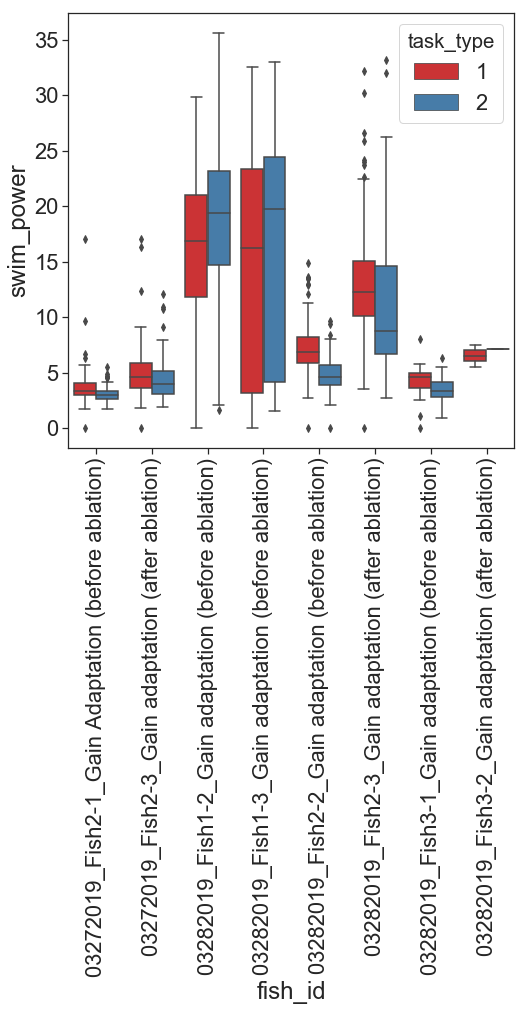

In [33]:
plt.figure(figsize=(8, 8))
sns.boxplot(x="fish_id", y="swim_power", hue="task_type", data=fish_behavior, palette="Set1")
plt.xticks(rotation=90)
plt.show()

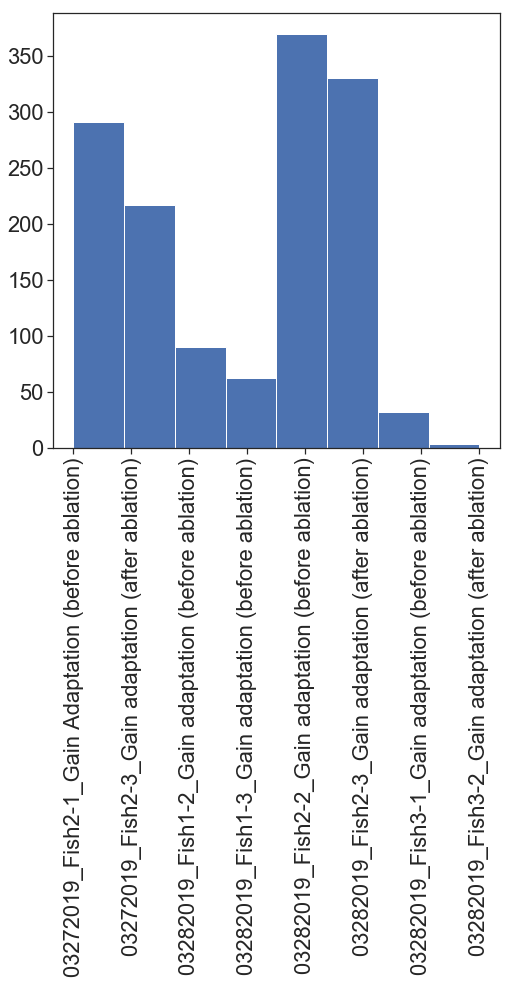

In [34]:
plt.figure(figsize=(8, 8))
plt.hist(fish_id, bins=len(np.unique(np.array(fish_id))))
plt.xticks(rotation=90)
plt.show()

In [29]:
np.unique(np.array(fish_id))

array(['03272019_Fish2-1_Gain Adaptation (before ablation)',
       '03272019_Fish2-3_Gain adaptation (after ablation)',
       '03282019_Fish1-2_Gain adaptation (before ablation)',
       '03282019_Fish1-3_Gain adaptation (before ablation)',
       '03282019_Fish2-2_Gain adaptation (before ablation)',
       '03282019_Fish2-3_Gain adaptation (after ablation)',
       '03282019_Fish3-1_Gain adaptation (before ablation)',
       '03282019_Fish3-2_Gain adaptation (after ablation)'], dtype='<U50')